In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score , classification_report,confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'

C:\Users\emirhan\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\emirhan\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
credit_risk = pd.read_csv("credit_risk.csv")
df = credit_risk.copy()

In [3]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
df.shape

(1000, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
Unnamed: 0          1000 non-null int64
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: int64(5), object(6)
memory usage: 86.0+ KB


In [6]:
df.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [7]:
df.drop("Unnamed: 0",axis = 1,
         inplace = True)

In [8]:
# Risk bağımlı değişkenimizi binary sınıfa dönüştürüyoruz.
df["Risk"].replace({"good":1,"bad":0},inplace = True) 

In [9]:
df["Sex"].replace({"male":1,"female":0},
                    inplace = True ) 

In [10]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,1,2,own,NaN,little,1169,6,radio/TV,1
1,22,0,2,own,little,moderate,5951,48,radio/TV,0
2,49,1,1,own,little,NaN,2096,12,education,1
3,45,1,2,free,little,little,7882,42,furniture/equipment,1
4,53,1,2,free,little,little,4870,24,car,0


# Genel Resim

## Kategorik Analiz

In [11]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]

In [12]:
cat_cols

['Housing', 'Saving accounts', 'Checking account', 'Purpose']

In [13]:
def cat_summary(data, categorical_cols, target, number_of_classes=10):
    var_count = 0
    vars_more_classes = []
    for var in categorical_cols:
        if len(data[var].value_counts()) <= number_of_classes:  # sınıf sayısına göre seç
            print(pd.DataFrame({var: data[var].value_counts(),
                                "Ratio": 100 * data[var].value_counts() / len(data),
                                "TARGET_MEAN": data.groupby(var)[target].mean()}), end="\n\n\n")
            var_count += 1
        else:
            vars_more_classes.append(data[var].name)
    print('%d categorical variables have been described' % var_count, end="\n\n")
    print('There are', len(vars_more_classes), "variables have more than", number_of_classes, "classes", end="\n\n")
    print('Variable names have more than %d classes:' % number_of_classes, end="\n\n")
    print(vars_more_classes)

In [14]:
cat_summary(df,cat_cols,"Risk")

      Housing  Ratio  TARGET_MEAN
free      108   10.8     0.592593
own       713   71.3     0.739130
rent      179   17.9     0.608939


                 Saving accounts  Ratio  TARGET_MEAN
Saving accounts                                     
little                       603   60.3     0.640133
moderate                     103   10.3     0.669903
quite rich                    63    6.3     0.825397
rich                          48    4.8     0.875000


                  Checking account  Ratio  TARGET_MEAN
Checking account                                      
little                         274   27.4     0.507299
moderate                       269   26.9     0.609665
rich                            63    6.3     0.777778


                     Purpose  Ratio  TARGET_MEAN
business                  97    9.7     0.649485
car                      337   33.7     0.685460
domestic appliances       12    1.2     0.666667
education                 59    5.9     0.610169
furniture/equipment 

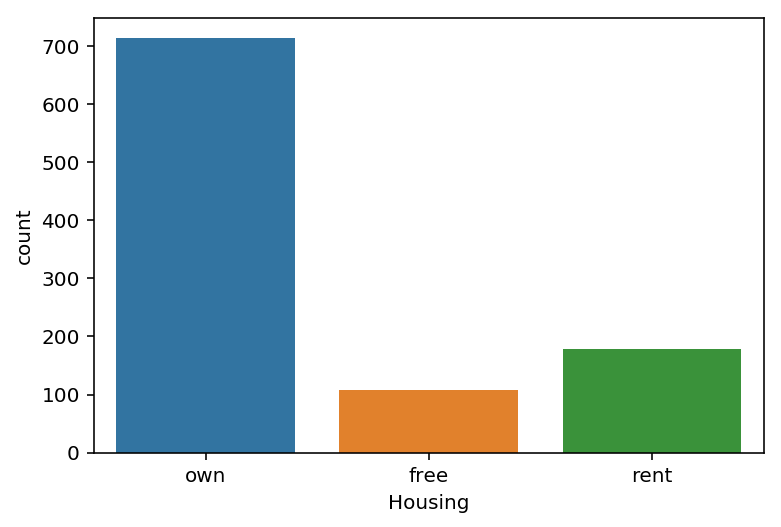

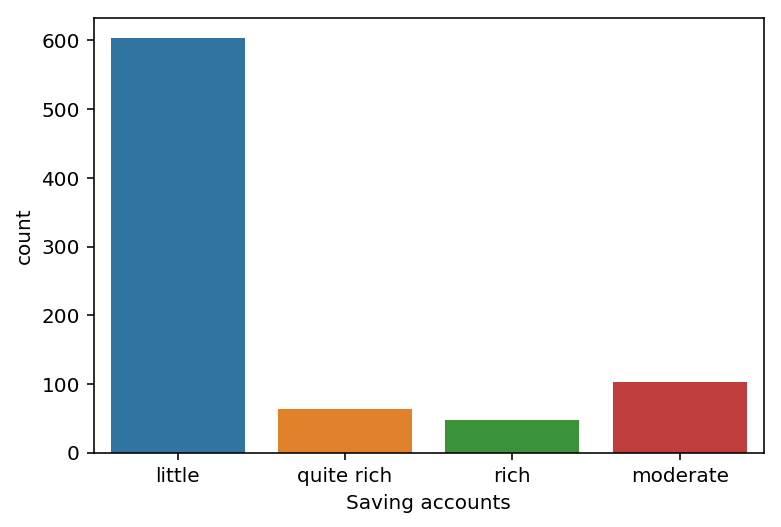

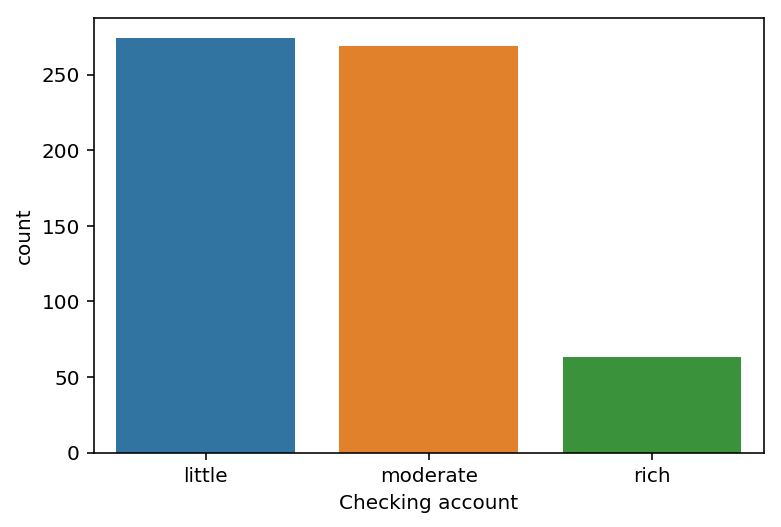

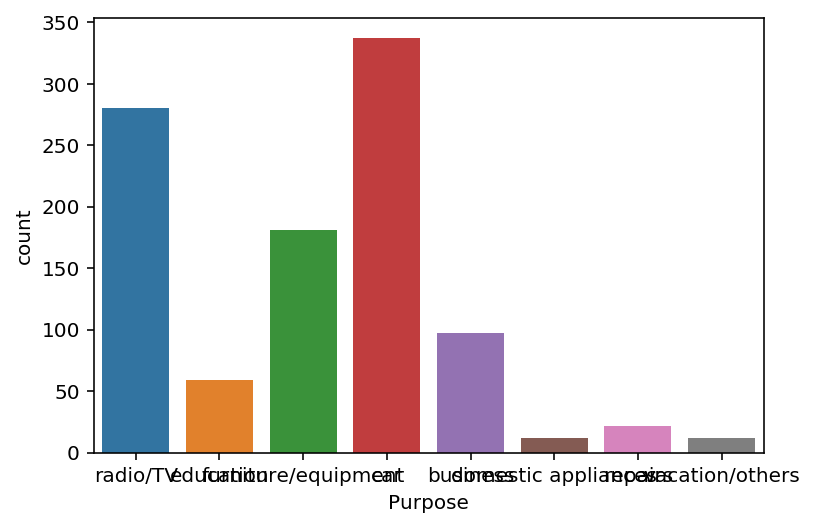

In [15]:
for col in cat_cols:
    sns.countplot(x=col, data=df)
    plt.show()

In [16]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in "Risk" and col not in "Job"]

In [17]:
# %99 dilim ile max değerlerimize baktığımızda bazı değişkenlerimizde kabaca aykırı gözlemler olduğunu gözlemleyebiliyoruz.
df.describe([.01,.25,.50,.75,.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
Age,1000.0,35.546,11.375469,19.0,20.00,27.0,33.0,42.00,67.01,75.0
Sex,1000.0,0.690,0.462725,0.0,0.00,0.0,1.0,1.00,1.00,1.0
Job,1000.0,1.904,0.653614,0.0,0.00,2.0,2.0,2.00,3.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,425.83,1365.5,2319.5,3972.25,14180.39,18424.0
Duration,1000.0,20.903,12.058814,4.0,6.00,12.0,18.0,24.00,60.00,72.0
Risk,1000.0,0.700,0.458487,0.0,0.00,0.0,1.0,1.00,1.00,1.0


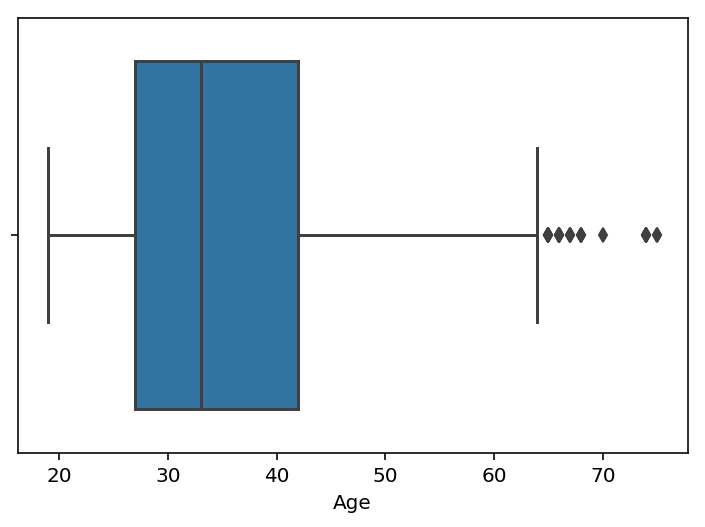

In [18]:
sns.boxplot(df.Age)

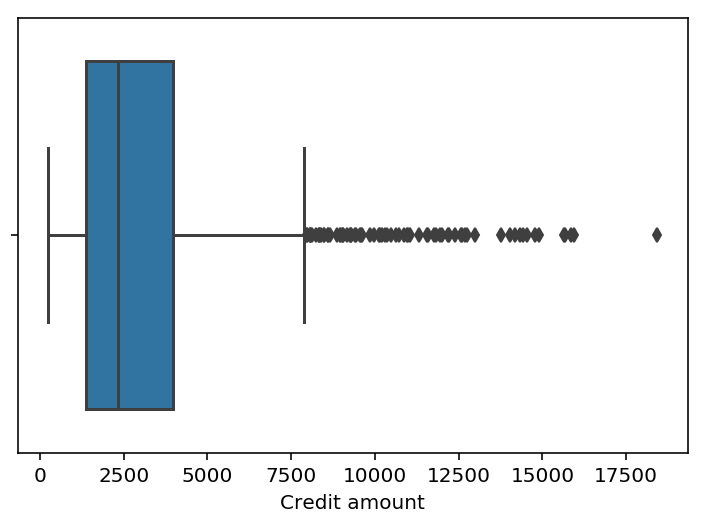

In [19]:
sns.boxplot(df["Credit amount"])

In [20]:
# Boxplot kullanarak credit amount ve yaş değişkeninde aykırı değerleri görebiliyoruz.

In [21]:
# Yaş değişkenimizi yaş aralıklarına göre bölmek istedik.
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

In [22]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,67,1,2,own,NaN,little,1169,6,radio/TV,1,Senior
1,22,0,2,own,little,moderate,5951,48,radio/TV,0,Student
2,49,1,1,own,little,NaN,2096,12,education,1,Adult
3,45,1,2,free,little,little,7882,42,furniture/equipment,1,Adult
4,53,1,2,free,little,little,4870,24,car,0,Adult


In [23]:
def rare_analyser(dataframe, target, rare_perc):
    rare_columns = [col for col in dataframe.columns if len(dataframe[col].value_counts()) <= 20
                    and (dataframe[col].value_counts() / len(dataframe) < rare_perc).any(axis=None)]
    for var in rare_columns:
        print(var, ":", len(dataframe[var].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[var].value_counts(),
                            "RATIO": dataframe[var].value_counts() / len(dataframe),
                            "TARGET_MEDIAN": dataframe.groupby(var)[target].median()}), end="\n\n\n")

In [24]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]
    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df


In [25]:
# Bu fonksiyon sayesinde oranca veri setinde yeterli olan sınıfları görmemizi sağladık.
rare_analyser(df,"Risk",0.04)

Job : 4
   COUNT  RATIO  TARGET_MEDIAN
0     22  0.022              1
1    200  0.200              1
2    630  0.630              1
3    148  0.148              1


Purpose : 8
                     COUNT  RATIO  TARGET_MEDIAN
business                97  0.097              1
car                    337  0.337              1
domestic appliances     12  0.012              1
education               59  0.059              1
furniture/equipment    181  0.181              1
radio/TV               280  0.280              1
repairs                 22  0.022              1
vacation/others         12  0.012              1




In [26]:
# Veri setinde gözlem sayılarının az olmasından dolayı çok anlam ifade etmeyecek olan sınıflarımızı raare sınıfına dönüştürelim.

In [27]:
df2 = rare_encoder(df,0.04)

In [28]:
df2.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,67,1,2,own,NaN,little,1169,6,radio/TV,1,Senior
1,22,0,2,own,little,moderate,5951,48,radio/TV,0,Student
2,49,1,1,own,little,NaN,2096,12,education,1,Adult
3,45,1,2,free,little,little,7882,42,furniture/equipment,1,Adult
4,53,1,2,free,little,little,4870,24,car,0,Adult


In [29]:
cat_summary(df2,cat_cols,"Risk")

      Housing  Ratio  TARGET_MEAN
free      108   10.8     0.592593
own       713   71.3     0.739130
rent      179   17.9     0.608939


                 Saving accounts  Ratio  TARGET_MEAN
Saving accounts                                     
little                       603   60.3     0.640133
moderate                     103   10.3     0.669903
quite rich                    63    6.3     0.825397
rich                          48    4.8     0.875000


                  Checking account  Ratio  TARGET_MEAN
Checking account                                      
little                         274   27.4     0.507299
moderate                       269   26.9     0.609665
rich                            63    6.3     0.777778


                     Purpose  Ratio  TARGET_MEAN
Rare                      46    4.6     0.630435
business                  97    9.7     0.649485
car                      337   33.7     0.685460
education                 59    5.9     0.610169
furniture/equipment 

In [30]:
#uyguladığımız rare fonksiyonu ile örneğin başta 8 olan purpose değişkeninin sınıf sayısını 6 sınıfa düşürdük. Rare sınıfının içerisine sayıca yetersiz sınıfları birleştirmiş olduk.

In [31]:
df2["Saving accounts"].fillna(df2["Saving accounts"].mode()[0],inplace = True)

In [32]:
df2["Checking account"].fillna(df2["Checking account"].mode()[0],inplace = True)

In [33]:
df2.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
Age_cat             0
dtype: int64

In [34]:
def outlier_thresholds(dataframe, variable):
    quartile1=dataframe[variable].quantile(0.25)
    quartile3=dataframe[variable].quantile(0.75)
    interquantile_range=quartile3-quartile1
    up_limit=quartile3+ 1.5*interquantile_range
    low_limit=quartile1-1.5*interquantile_range
    return low_limit, up_limit

In [35]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [36]:
outlier_columns = ["Age","Credit amount"]

In [37]:
for col in outlier_columns:
    replace_with_thresholds(df2,col)

In [38]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.4535,11.106324,19.0,27.0,33.0,42.00,64.500
Sex,1000.0,0.6900,0.462725,0.0,0.0,1.0,1.00,1.000
Job,1000.0,1.9040,0.653614,0.0,2.0,2.0,2.00,3.000
Credit amount,1000.0,3051.1010,2187.140403,250.0,1365.5,2319.5,3972.25,7882.375
Duration,1000.0,20.9030,12.058814,4.0,12.0,18.0,24.00,72.000
Risk,1000.0,0.7000,0.458487,0.0,0.0,1.0,1.00,1.000


In [39]:
# Kredi ödeme süresinide kısa dönem (0-24 ay), orta vade(24-48 ay), uzun vade(48-72 ay ) olarak böldük
interval = (0, 24, 48, 73 )

cats = ['short_tenor', 'middle_tenor', 'Long_Tenor']
df2["Duration_tenor"] = pd.cut(df2.Duration, interval, labels=cats)

In [40]:
cat_summary(df2,cat_cols,"Risk")

      Housing  Ratio  TARGET_MEAN
free      108   10.8     0.592593
own       713   71.3     0.739130
rent      179   17.9     0.608939


                 Saving accounts  Ratio  TARGET_MEAN
Saving accounts                                     
little                       786   78.6     0.683206
moderate                     103   10.3     0.669903
quite rich                    63    6.3     0.825397
rich                          48    4.8     0.875000


                  Checking account  Ratio  TARGET_MEAN
Checking account                                      
little                         668   66.8     0.729042
moderate                       269   26.9     0.609665
rich                            63    6.3     0.777778


                     Purpose  Ratio  TARGET_MEAN
Rare                      46    4.6     0.630435
business                  97    9.7     0.649485
car                      337   33.7     0.685460
education                 59    5.9     0.610169
furniture/equipment 

In [41]:
df2.loc[(df2["Saving accounts"] == "little"),"Saving accounts"] = 1
df2.loc[(df2["Saving accounts"] == "moderate"),"Saving accounts"] = 2
df2.loc[(df2["Saving accounts"] == "quite rich"),"Saving accounts"] = 3
df2.loc[(df2["Saving accounts"] == "rich"),"Saving accounts"] = 4

In [42]:
# Aralıklandırdığımız age_cat ve duration_tenor değişkenlerininin category tiplerini object yapalım.
df2["Age_cat"] = df2["Age_cat"].astype("object")
df2["Duration_tenor"] = df2["Duration_tenor"].astype("object")

In [43]:
df2.loc[(df2["Duration_tenor"] == "short_tenor"),"Duration_tenor"] = 1
df2.loc[(df2["Duration_tenor"] == "middle_tenor"),"Duration_tenor"] = 2
df2.loc[(df2["Duration_tenor"] == "Long_Tenor"),"Duration_tenor"] = 3

In [44]:
df2.head() 

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat,Duration_tenor
0,64.5,1,2,own,1,little,1169.0,6,radio/TV,1,Senior,1
1,22.0,0,2,own,1,moderate,5951.0,48,radio/TV,0,Student,2
2,49.0,1,1,own,1,little,2096.0,12,education,1,Adult,1
3,45.0,1,2,free,1,little,7882.0,42,furniture/equipment,1,Adult,2
4,53.0,1,2,free,1,little,4870.0,24,car,0,Adult,1


In [45]:
df2["payment_amount"] = df2["Credit amount"] / df2["Duration"]

In [46]:
df2.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat,Duration_tenor,payment_amount
0,64.5,1,2,own,1,little,1169.0,6,radio/TV,1,Senior,1,194.833333
1,22.0,0,2,own,1,moderate,5951.0,48,radio/TV,0,Student,2,123.979167
2,49.0,1,1,own,1,little,2096.0,12,education,1,Adult,1,174.666667
3,45.0,1,2,free,1,little,7882.0,42,furniture/equipment,1,Adult,2,187.666667
4,53.0,1,2,free,1,little,4870.0,24,car,0,Adult,1,202.916667


In [47]:
df2.drop("Purpose",
         axis = 1,
         inplace = True)

In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
Age                 1000 non-null float64
Sex                 1000 non-null int64
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     1000 non-null int64
Checking account    1000 non-null object
Credit amount       1000 non-null float64
Duration            1000 non-null int64
Risk                1000 non-null int64
Age_cat             1000 non-null object
Duration_tenor      1000 non-null int64
payment_amount      1000 non-null float64
dtypes: float64(3), int64(6), object(3)
memory usage: 93.8+ KB


In [49]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [50]:
df3,new_columns = one_hot_encoder(df2)

In [51]:
df3 = pd.DataFrame(df3)

In [52]:
df3.head()

,Age,Sex,Job,Saving accounts,Credit amount,Duration,Risk,Duration_tenor,payment_amount,Housing_own,Housing_rent,Checking account_moderate,Checking account_rich,Age_cat_Senior,Age_cat_Student,Age_cat_Young
0,64.5,1,2,1,1169.0,6,1,1,194.833333,1,0,0,0,1,0,0
1,22.0,0,2,1,5951.0,48,0,2,123.979167,1,0,1,0,0,1,0
2,49.0,1,1,1,2096.0,12,1,1,174.666667,1,0,0,0,0,0,0
3,45.0,1,2,1,7882.0,42,1,2,187.666667,0,0,0,0,0,0,0
4,53.0,1,2,1,4870.0,24,0,1,202.916667,0,0,0,0,0,0,0


In [53]:
df3.isnull().sum()

Age                          0
Sex                          0
Job                          0
Saving accounts              0
Credit amount                0
Duration                     0
Risk                         0
Duration_tenor               0
payment_amount               0
Housing_own                  0
Housing_rent                 0
Checking account_moderate    0
Checking account_rich        0
Age_cat_Senior               0
Age_cat_Student              0
Age_cat_Young                0
dtype: int64

In [54]:
df3.head()

,Age,Sex,Job,Saving accounts,Credit amount,Duration,Risk,Duration_tenor,payment_amount,Housing_own,Housing_rent,Checking account_moderate,Checking account_rich,Age_cat_Senior,Age_cat_Student,Age_cat_Young
0,64.5,1,2,1,1169.0,6,1,1,194.833333,1,0,0,0,1,0,0
1,22.0,0,2,1,5951.0,48,0,2,123.979167,1,0,1,0,0,1,0
2,49.0,1,1,1,2096.0,12,1,1,174.666667,1,0,0,0,0,0,0
3,45.0,1,2,1,7882.0,42,1,2,187.666667,0,0,0,0,0,0,0
4,53.0,1,2,1,4870.0,24,0,1,202.916667,0,0,0,0,0,0,0


In [55]:
df5 = df3.drop(["Age","Duration"],axis = 1)
df5.head()

,Sex,Job,Saving accounts,Credit amount,Risk,Duration_tenor,payment_amount,Housing_own,Housing_rent,Checking account_moderate,Checking account_rich,Age_cat_Senior,Age_cat_Student,Age_cat_Young
0,1,2,1,1169.0,1,1,194.833333,1,0,0,0,1,0,0
1,0,2,1,5951.0,0,2,123.979167,1,0,1,0,0,1,0
2,1,1,1,2096.0,1,1,174.666667,1,0,0,0,0,0,0
3,1,2,1,7882.0,1,2,187.666667,0,0,0,0,0,0,0
4,1,2,1,4870.0,0,1,202.916667,0,0,0,0,0,0,0


## CROSS VALİDATİON YÖNTEMİ

Gözlem sayımız düşük olduğu için Cross validation gerçekleştiriyoruz.

In [56]:
## Her model için ortalama Cross validation skorlarına bakalım

y = df5["Risk"]
X = df5.drop(["Risk"], axis = 1)



models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(("LightGBM", LGBMClassifier()))

# evaluate each model in turn
results = []
names = []



for name, model in models:
    
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

LR: 0.713000 (0.031000)
CART: 0.613000 (0.036620)
RF: 0.692000 (0.029257)
LightGBM: 0.676000 (0.030725)


Random forest modelimiz için 0.69 accuracy hesapladık. Modelimiz tuned etmek için bu sefer tek başına sadece random forest modeli oluşturuyoruz.

### Random Forest

In [65]:
RF = RandomForestClassifier(random_state = 123)

In [67]:
cros_val = cross_val_score(RF,X,y,cv = 10 ,scoring = "accuracy")

In [68]:
cros_val.mean()

0.6900000000000001

#### Model Tuned

In [81]:
rf_params = {"n_estimators":[100,200,500,1000],
             "max_features":[3,5,7,10,15,20],
             "min_samples_split": [2,5,10,30],
             "max_depth": [3,5,8,None]}

In [82]:
RF = RandomForestClassifier(random_state = 123)

In [83]:
gs_cv = GridSearchCV(RF,
                     rf_params,
                     cv = 10,
                     n_jobs = -1,
                     verbose = 2)

In [84]:
gs_cv.fit(X,y)

Fitting 10 folds for each of 384 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:  7.4min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=123,
                                

In [85]:
gs_cv.best_params_

{'max_depth': 5,
 'max_features': 7,
 'min_samples_split': 30,
 'n_estimators': 500}

In [86]:
RF_tuned = RandomForestClassifier(**gs_cv.best_params_,random_state = 123)

In [87]:
RF_tuned.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [88]:
cros_val = cross_val_score(RF_tuned,X,y,cv = 10 ,scoring = "accuracy")
cros_val.mean()

0.728

In [90]:
print(RF_tuned.feature_importances_)

[0.01916754 0.0286877  0.05193336 0.30007135 0.08915958 0.30601495
 0.05485334 0.02458685 0.03792678 0.00621077 0.00515083 0.06038926
 0.01584771]


In [97]:
# Bir tahminde bulunalım.
RF_tuned.predict_proba([[0,1,0,15000,3,230,1,0,0,1,0,0,1]])[0]

array([0.40071373, 0.59928627])

modelimize girmiş olduğumuz verilerimze göre;
- Bu kişi %60 olasılıkla 1 sınıfında yani good risk sınıfındadır.
- %40 olasılıkla 0 sınıfındadır. Yani bad risk.